# **install**

In [1]:
!pip install pybullet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 91.7 MB 27 kB/s 


In [2]:
!pip install ptan

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 776.7 MB 4.2 kB/s 
  Created wheel for ptan: filename=ptan-0.7-py3-none-any.whl size=23505 sha256=c1f3da982f0d0dcb4e2f9a1c423669402e3729e963f82048cead7bdab8dac085
  Stored in directory: /root/.cache/pip/wheels/60/72/3d/a3c47193fdb9efd08e3a54398af996b2989c68571813a71256
Successfully built ptan
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:
      Successfully uninstalled torch-1.11.0+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.12.0+cu113 requires torch==1.11.0, but you have torch 1.7.0 which is incompatible.
torchtext 0.12.0 requires torch==1.11.0, but you have torch 1.7.0 which is incompatible.
torchaudio 0.11.0+cu113 requires torc

In [3]:
!pip install tensorboardX

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 15.1 MB/s 


In [4]:
from google.colab import drive
drive.mount('./mount')

Mounted at ./mount


# **explore**

In [ ]:
import gym
import pybullet_envs

env = gym.make("MinitaurBulletEnv-v0")

urdf_root=/usr/local/lib/python3.7/dist-packages/pybullet_data


/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


(720, 960, 3)


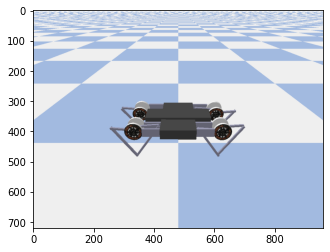

In [ ]:
xxx = env.render('rgb_array')
print(xxx.shape)

import matplotlib.pyplot as plt
plt.imshow(xxx)

In [ ]:
# video recorder import
from gym.wrappers.monitoring.video_recorder import VideoRecorder

# video -> html function
from base64 import b64encode
def render_mp4(videopath: str) -> str:
  """
  Gets a string containing a b4-encoded version of the MP4 video
  at the specified path.
  """
  mp4 = open(videopath, 'rb').read()
  base64_encoded_mp4 = b64encode(mp4).decode()
  return f'<video width=400 controls><source src="data:video/mp4;' \
         f'base64,{base64_encoded_mp4}" type="video/mp4"></video>'

In [ ]:
# video record

minitaur_training = "minitaur_training.mp4"
video = VideoRecorder(env, minitaur_training)

state = env.reset()
done = False
while not done:
  env.render()
  video.capture_frame()
  action = env.action_space.sample()
  _, _, done, info = env.step(action)

  pass

env.render()
video.capture_frame()

video.close()
env.close()

In [ ]:
# video play

from IPython.display import HTML
html = render_mp4(minitaur_training)
HTML(html)

Output hidden; open in https://colab.research.google.com to view.

# **model**

In [5]:
import ptan
import numpy as np
import torch
import torch.nn as nn

HID_SIZE = 64


class ModelActor(nn.Module):
    def __init__(self, obs_size, act_size):
        super(ModelActor, self).__init__()

        self.mu = nn.Sequential(
            nn.Linear(obs_size, HID_SIZE),
            nn.ReLU(),    ####
            nn.Linear(HID_SIZE, HID_SIZE),
            nn.ReLU(),    ####
            nn.Linear(HID_SIZE, act_size),
            nn.Tanh(),
        )
        self.logstd = nn.Parameter(torch.zeros(act_size))

    def forward(self, x):
        return self.mu(x)


class ModelCritic(nn.Module):
    def __init__(self, obs_size):
        super(ModelCritic, self).__init__()

        self.value = nn.Sequential(
            nn.Linear(obs_size, HID_SIZE),
            nn.ReLU(),
            nn.Linear(HID_SIZE, HID_SIZE),
            nn.ReLU(),
            nn.Linear(HID_SIZE, 1),
        )

    def forward(self, x):
        return self.value(x)


class ModelSACTwinQ(nn.Module):
    def __init__(self, obs_size, act_size):
        super(ModelSACTwinQ, self).__init__()

        self.q1 = nn.Sequential(
            nn.Linear(obs_size + act_size, HID_SIZE),
            nn.ReLU(),
            nn.Linear(HID_SIZE, HID_SIZE),
            nn.ReLU(),
            nn.Linear(HID_SIZE, 1),
        )

        self.q2 = nn.Sequential(
            nn.Linear(obs_size + act_size, HID_SIZE),
            nn.ReLU(),
            nn.Linear(HID_SIZE, HID_SIZE),
            nn.ReLU(),
            nn.Linear(HID_SIZE, 1),
        )

    def forward(self, obs, act):
        x = torch.cat([obs, act], dim=1)
        return self.q1(x), self.q2(x)


class AgentA2C(ptan.agent.BaseAgent):
    def __init__(self, net, device="cpu"):
        self.net = net
        self.device = device

    def __call__(self, states, agent_states):
        states_v = ptan.agent.float32_preprocessor(states)
        states_v = states_v.to(self.device)

        mu_v = self.net(states_v)
        mu = mu_v.data.cpu().numpy()
        logstd = self.net.logstd.data.cpu().numpy()
        rnd = np.random.normal(size=logstd.shape)
        actions = mu + np.exp(logstd) * rnd
        actions = np.clip(actions, -1, 1)
        return actions, agent_states


class AgentDDPG(ptan.agent.BaseAgent):
    """
    Agent implementing Orstein-Uhlenbeck exploration process
    """
    def __init__(self, net, device="cpu", ou_enabled=True,
                 ou_mu=0.0, ou_teta=0.15, ou_sigma=0.2,
                 ou_epsilon=1.0):
        self.net = net
        self.device = device
        self.ou_enabled = ou_enabled
        self.ou_mu = ou_mu
        self.ou_teta = ou_teta
        self.ou_sigma = ou_sigma
        self.ou_epsilon = ou_epsilon

    def initial_state(self):
        return None

    def __call__(self, states, agent_states):
        states_v = ptan.agent.float32_preprocessor(states)
        states_v = states_v.to(self.device)
        mu_v = self.net(states_v)
        actions = mu_v.data.cpu().numpy()

        if self.ou_enabled and self.ou_epsilon > 0:
            new_a_states = []
            for a_state, action in zip(agent_states, actions):
                if a_state is None:
                    a_state = np.zeros(
                        shape=action.shape, dtype=np.float32)
                a_state += self.ou_teta * (self.ou_mu - a_state)
                a_state += self.ou_sigma * np.random.normal(
                    size=action.shape)

                action += self.ou_epsilon * a_state
                new_a_states.append(a_state)
        else:
            new_a_states = agent_states

        actions = np.clip(actions, -1, 1)
        return actions, new_a_states

# **common**

In [6]:
import numpy as np
import torch
import torch.distributions as distr

import ptan


def unpack_batch_a2c(batch, net, last_val_gamma, device="cpu"):
    """
    Convert batch into training tensors
    :param batch:
    :param net:
    :return: states variable, actions tensor, reference values variable
    """
    states = []
    actions = []
    rewards = []
    not_done_idx = []
    last_states = []
    for idx, exp in enumerate(batch):
        states.append(exp.state)
        actions.append(exp.action)
        rewards.append(exp.reward)
        if exp.last_state is not None:
            not_done_idx.append(idx)
            last_states.append(exp.last_state)
    states_v = ptan.agent.float32_preprocessor(states).to(device)
    actions_v = torch.FloatTensor(actions).to(device)

    # handle rewards
    rewards_np = np.array(rewards, dtype=np.float32)
    if not_done_idx:
        last_states_v = ptan.agent.float32_preprocessor(last_states).to(device)
        last_vals_v = net(last_states_v)
        last_vals_np = last_vals_v.data.cpu().numpy()[:, 0]
        rewards_np[not_done_idx] += last_val_gamma * last_vals_np

    ref_vals_v = torch.FloatTensor(rewards_np).to(device)
    return states_v, actions_v, ref_vals_v


@torch.no_grad()
def unpack_batch_sac(batch, val_net, twinq_net, policy_net,
                     gamma: float, ent_alpha: float,
                     device="cpu"):
    """
    Unpack Soft Actor-Critic batch
    """
    states_v, actions_v, ref_q_v = \
        unpack_batch_a2c(batch, val_net, gamma, device)

    # references for the critic network
    mu_v = policy_net(states_v)
    act_dist = distr.Normal(mu_v, torch.exp(policy_net.logstd))
    acts_v = act_dist.sample()
    q1_v, q2_v = twinq_net(states_v, acts_v)
    # element-wise minimum
    ref_vals_v = torch.min(q1_v, q2_v).squeeze() - \
                 ent_alpha * act_dist.log_prob(acts_v).sum(dim=1)
    return states_v, actions_v, ref_vals_v, ref_q_v

# **import & define**

In [7]:
# cuda or not
import torch

if torch.cuda.is_available():
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
  print("using cuda:",torch.cuda.get_device_name(0))
  pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

using cuda: Tesla T4


device(type='cuda')

In [11]:
import os
import ptan
import gym
import math
import time
import pybullet_envs
# import argparse
from tensorboardX import SummaryWriter
import numpy as np

import torch
import torch.optim as optim
import torch.distributions as distrib
import torch.nn.functional as F


ENV_ID = "MinitaurBulletEnv-v0"
GAMMA = 0.99
BATCH_SIZE = 64
LR_ACTS = 1e-4
LR_VALS = 1e-4
REPLAY_SIZE = 100000
REPLAY_INITIAL = 10000
SAC_ENTROPY_ALPHA = 0.001

TEST_ITERS = 10000


def test_net(net, env, count=10, device="cpu"):
    rewards = 0.0
    steps = 0
    for _ in range(count):
        obs = env.reset()
        while True:
            obs_v = ptan.agent.float32_preprocessor([obs])
            obs_v = obs_v.to(device)

            mu_v = net(obs_v)
            mu = mu_v.data.cpu().numpy().squeeze()
            actions = np.clip(mu, -1, 1)

            obs, reward, done, _ = env.step(actions)

            rewards += reward
            steps += 1
            if done:
                break
    return rewards / count, steps / count


In [12]:
# setup

save_path = os.path.join('mount/My Drive/Colab Notebooks/minitaur_', '04_22060313_SAC')
os.makedirs(save_path, exist_ok=True)

env = gym.make(ENV_ID)
test_env = gym.make(ENV_ID)

act_net = ModelActor(
    env.observation_space.shape[0],
    env.action_space.shape[0]).to(device)
crt_net = ModelCritic(
    env.observation_space.shape[0]
).to(device)
twinq_net = ModelSACTwinQ(
    env.observation_space.shape[0],
    env.action_space.shape[0]).to(device)
print(act_net)
print(crt_net)
print(twinq_net)

tgt_crt_net = ptan.agent.TargetNet(crt_net)

writer = SummaryWriter(comment="-sac_")
agent = AgentDDPG(act_net, device=device)
exp_source = ptan.experience.ExperienceSourceFirstLast(
    env, agent, gamma=GAMMA, steps_count=1)
buffer = ptan.experience.ExperienceReplayBuffer(
    exp_source, buffer_size=REPLAY_SIZE)
act_opt = optim.Adam(act_net.parameters(), lr=LR_ACTS)
crt_opt = optim.Adam(crt_net.parameters(), lr=LR_VALS)
twinq_opt = optim.Adam(twinq_net.parameters(), lr=LR_VALS)

urdf_root=/usr/local/lib/python3.7/dist-packages/pybullet_data
urdf_root=/usr/local/lib/python3.7/dist-packages/pybullet_data
ModelActor(
  (mu): Sequential(
    (0): Linear(in_features=28, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=8, bias=True)
    (5): Tanh()
  )
)
ModelCritic(
  (value): Sequential(
    (0): Linear(in_features=28, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)
ModelSACTwinQ(
  (q1): Sequential(
    (0): Linear(in_features=36, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
  (q2): Sequential(
    (0): Linear(in_features=36, out_features=64, bias=True)
    (1): ReLU()
    (2): L

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


# **train**

In [13]:
frame_idx = 0
best_reward = None

In [14]:
best_reward = None
with ptan.common.utils.RewardTracker(writer) as tracker:
    with ptan.common.utils.TBMeanTracker(
            writer, batch_size=10) as tb_tracker:
        while True:
            frame_idx += 1
            buffer.populate(1)
            rewards_steps = exp_source.pop_rewards_steps()
            if rewards_steps:
                rewards, steps = zip(*rewards_steps)
                tb_tracker.track("episode_steps", steps[0], frame_idx)
                tracker.reward(rewards[0], frame_idx)

            if len(buffer) < REPLAY_INITIAL:
                continue

            batch = buffer.sample(BATCH_SIZE)
            states_v, actions_v, ref_vals_v, ref_q_v = \
                unpack_batch_sac(
                    batch, tgt_crt_net.target_model,
                    twinq_net, act_net, GAMMA,
                    SAC_ENTROPY_ALPHA, device)

            tb_tracker.track("ref_v", ref_vals_v.mean(), frame_idx)
            tb_tracker.track("ref_q", ref_q_v.mean(), frame_idx)

            # Critic
            crt_opt.zero_grad()
            val_v = crt_net(states_v)
            v_loss_v = F.mse_loss(val_v.squeeze(),
                                  ref_vals_v.detach())
            v_loss_v.backward()
            crt_opt.step()
            tb_tracker.track("loss_v", v_loss_v, frame_idx)

            # train TwinQ
            twinq_opt.zero_grad()
            q1_v, q2_v = twinq_net(states_v, actions_v)
            q1_loss_v = F.mse_loss(q1_v.squeeze(),
                                    ref_q_v.detach())
            q2_loss_v = F.mse_loss(q2_v.squeeze(),
                                    ref_q_v.detach())
            q_loss_v = q1_loss_v + q2_loss_v
            q_loss_v.backward()
            twinq_opt.step()
            tb_tracker.track("loss_q1", q1_loss_v, frame_idx)
            tb_tracker.track("loss_q2", q2_loss_v, frame_idx)

            # Actor
            act_opt.zero_grad()
            acts_v = act_net(states_v)
            q_out_v, _ = twinq_net(states_v, acts_v)
            act_loss = -q_out_v.mean()
            act_loss.backward()
            act_opt.step()
            tb_tracker.track("loss_act", act_loss, frame_idx)

            tgt_crt_net.alpha_sync(alpha=1 - 1e-3)

            if frame_idx % TEST_ITERS == 0:
                ts = time.time()
                rewards, steps = test_net(act_net, test_env, device=device)
                print("Test done in %.2f sec, reward %.3f, steps %d" % (
                    time.time() - ts, rewards, steps))
                writer.add_scalar("test_reward", rewards, frame_idx)
                writer.add_scalar("test_steps", steps, frame_idx)
                if best_reward is None or best_reward < rewards:
                    if best_reward is not None:
                        print("Best reward updated: %.3f -> %.3f" % (best_reward, rewards))
                        name = "best_%+.3f_%d.dat" % (rewards, frame_idx)
                        fname = os.path.join(save_path, name)
                        torch.save(act_net.state_dict(), fname)
                    best_reward = rewards


128: done 1 episodes, mean reward 0.021, speed 117.18 f/s
261: done 3 episodes, mean reward -0.019, speed 126.77 f/s
396: done 5 episodes, mean reward 0.017, speed 111.47 f/s
556: done 7 episodes, mean reward 0.036, speed 123.84 f/s
791: done 9 episodes, mean reward 0.028, speed 133.90 f/s
1159: done 11 episodes, mean reward 0.040, speed 143.01 f/s
1302: done 13 episodes, mean reward 0.013, speed 123.37 f/s
1439: done 15 episodes, mean reward 0.004, speed 120.65 f/s
1704: done 16 episodes, mean reward -0.019, speed 148.75 f/s
1860: done 18 episodes, mean reward -0.024, speed 126.53 f/s
2127: done 21 episodes, mean reward -0.020, speed 121.91 f/s
2256: done 23 episodes, mean reward -0.017, speed 117.28 f/s
2392: done 25 episodes, mean reward -0.019, speed 123.33 f/s
2708: done 26 episodes, mean reward -0.014, speed 152.13 f/s
3068: done 27 episodes, mean reward -0.018, speed 149.84 f/s
3247: done 28 episodes, mean reward -0.014, speed 151.32 f/s
3450: done 30 episodes, mean reward -0.01

KeyboardInterrupt: ignored

In [15]:
torch.save(act_net.state_dict(), 'mount/My Drive/Colab Notebooks/minitaur_/04_22060313_SAC/act_net.pth')
torch.save(crt_net.state_dict(), 'mount/My Drive/Colab Notebooks/minitaur_/04_22060313_SAC/crt_net.pth')
torch.save(twinq_net.state_dict(), 'mount/My Drive/Colab Notebooks/minitaur_/04_22060313_SAC/twinq_net.pth')

# **episode**

In [ ]:
# video recorder import
from gym.wrappers.monitoring.video_recorder import VideoRecorder

# video -> html function
from base64 import b64encode
def render_mp4(videopath: str) -> str:
  """
  Gets a string containing a b4-encoded version of the MP4 video
  at the specified path.
  """
  mp4 = open(videopath, 'rb').read()
  base64_encoded_mp4 = b64encode(mp4).decode()
  return f'<video width=400 controls><source src="data:video/mp4;' \
         f'base64,{base64_encoded_mp4}" type="video/mp4"></video>'

In [ ]:
# setup env & download model

env = gym.make("MinitaurBulletEnv-v0")

net = ModelActor(env.observation_space.shape[0], env.action_space.shape[0])
net.load_state_dict(torch.load('mount/My Drive/Colab Notebooks/minitaur_/04_22060313_SAC/act_net.pth'))

urdf_root=/usr/local/lib/python3.7/dist-packages/pybullet_data


/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


<All keys matched successfully>

In [ ]:
# video record

minitaur_training = "minitaur_training.mp4"
video = VideoRecorder(env, minitaur_training)

steps = 0
rewards = 0

state = env.reset()
done = False
while not done:
  env.render()
  video.capture_frame()

  state = torch.tensor(state, dtype=torch.float)
  action = net(state)
  action = action.squeeze(dim=0).data.cpu().numpy()
  action = np.clip(action, -1, 1)
  next_state, reward, done, info = env.step(action)

  state = next_state
  steps += 1
  rewards += reward

  pass

env.render()
video.capture_frame()

video.close()
env.close()

In [ ]:
print('steps:', steps)
print('rewards:', rewards)

steps: 316
rewards: -0.6418582077515349


In [ ]:
# video play

from IPython.display import HTML
html = render_mp4(minitaur_training)
HTML(html)

# **Assess**

In [ ]:
# setup env & download model

env = gym.make("MinitaurBulletEnv-v0")

net = ModelActor(env.observation_space.shape[0], env.action_space.shape[0])
net.load_state_dict(torch.load('mount/My Drive/Colab Notebooks/minitaur_/04_22060313_SAC/act_net.pth'))

urdf_root=/usr/local/lib/python3.7/dist-packages/pybullet_data


/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


<All keys matched successfully>

In [ ]:
# simulate

rewords_by_episodes = []
steps_by_episodes = []

for i in range(1):
  
  rewords = 0
  steps = 0

  state = env.reset()
  done = False
  while not done:

    state = torch.tensor(state, dtype=torch.float)
    action = net(state)
    
    VVVVC = crt_net(state)
    print('V value:', VVVVC)    

    action = action.squeeze(dim=0).data.cpu().numpy()
    action = np.clip(action, -1, 1)
    next_state, reword, done, info = env.step(action)

    ####
    break

    state = next_state
    rewords += reword
    steps += 1

    pass

  rewords_by_episodes.append(rewords)
  steps_by_episodes.append(steps)

  pass

env.close()

V value: tensor([54.8503], grad_fn=<AddBackward0>)


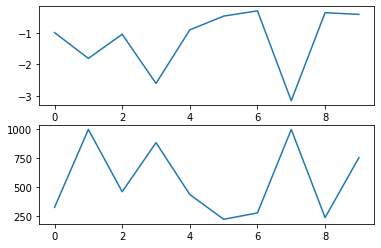

In [ ]:
# plot

import matplotlib.pyplot as plt

fig, ax = plt.subplots(2)
ax[0].plot(rewords_by_episodes)
ax[1].plot(steps_by_episodes)